# 精调 - 改善 MNIST 分类器

PyTorch 生成对抗式网络编程, 2020

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

## 定义数据集类

In [2]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        """
        Returns: 标签、图像、目标值
        """
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 图像数据，从 0~255 归一化为 0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # 返回：标签、图像数据张量、目标张量
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


## 载入数据

In [3]:
mnist_dataset = MnistDataset('datasets/mnist_train.csv')

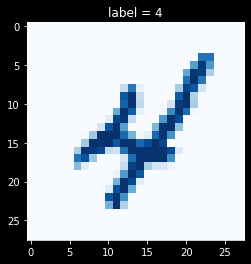

In [4]:
# 检查数据集

mnist_dataset.plot_image(9)

In [5]:
# 通过索引检查数据集类，得到：标签、图像值、目标张量

mnist_dataset[100]

(5,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

## 定义神经网络类

In [6]:
# 定义分类器类

class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.02), # 使用 LeakyReLU 代替 Sigmoid，避免训练过程中出现梯度消失的问题

            nn.LayerNorm(200),  # 归一化层，减少神经网络中参数和信号的取值范围，使得模型更加稳定
            
            nn.Linear(200, 10),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02) # 不能使用 LeakyReLU 代替 Sigmoid，因为输出不在 0~1 范围内
        )
        
        # 创建损失函数（使用 BCELoss 代替 MSELoss），二元交叉熵损失函数更适合这个问题
        #self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # 创建优化器（使用 Adam 代替 SGD），避免陷入局部最小值和单一学习率
        #self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters())

        # 计数和累积进度
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 计算网络输出
        outputs = self.forward(inputs)
        
        # 计算损失函数
        loss = self.loss_function(outputs, targets)

        # 相隔固定次数后增加计数和累积进度
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## 训练神经网络

In [7]:
C = Classifier()

# 基于 MNIST 数据集训练神经网络

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000


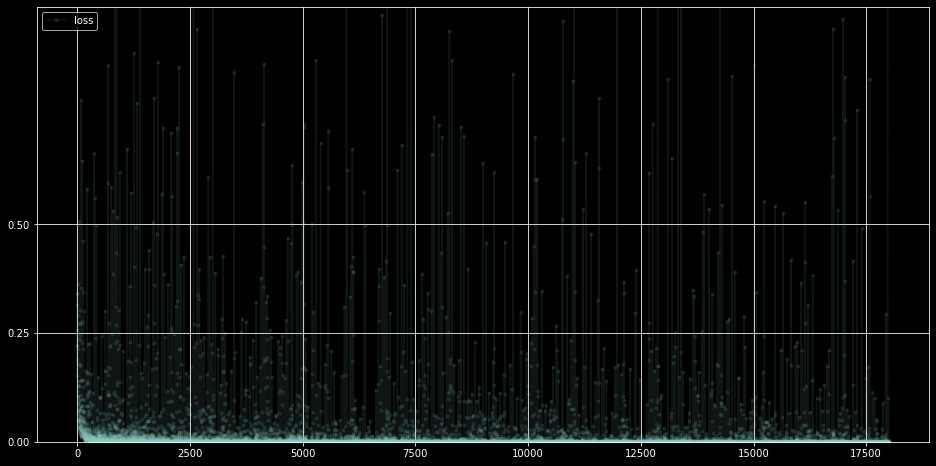

In [8]:
# plot classifier error

C.plot_progress()

## 分类器的样本

In [10]:
# 载入 MNIST 数据集中的测试数据

mnist_test_dataset = MnistDataset('datasets/mnist_test.csv')

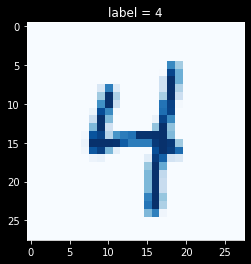

In [11]:
# 挑选一个数据记录
record = 19

# 绘制图像与标签
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

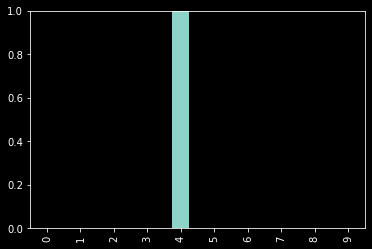

In [12]:
# 可视化神经网络输出的结果

image_data = mnist_test_dataset[record][1]

# 从训练后的网络中推理结果
output = C.forward(image_data)

# 绘制输出的图像
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## 分类器的性能

In [13]:
# 基于训练数据测试训练后的神经网络

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9726 10000 0.9726
